In [1]:
# A dependency of the preprocessing for BERT inputs
#!pip install -q -U tensorflow-text

In [2]:
#!pip install -q tf-models-official

In [3]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

In [4]:
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'


dataset = tf.keras.utils.get_file('aclImdb_v1.tar.gz', url,
                                  untar=True, cache_dir='.',
                                  cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

train_dir = os.path.join(dataset_dir, 'train')

# remove unused folders to make it easier to load the data
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [5]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [6]:
for text_batch, label_batch in train_ds.batch(3).take(1):
  print(text_batch.numpy())
  print("==========")
  print(label_batch.numpy())


[[b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
  b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into complicated situat

In [7]:
#Text inputs need to be transformed to numeric token ids and arranged in several Tensors before being input to BERT.
bert_preprocess_model = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1")

In [8]:
text_test=["This is such an amazing movie"]

text_preprocessed=bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')


Keys       : ['input_word_ids', 'input_mask', 'input_type_ids']
Shape      : (1, 128)


In [9]:
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  102    0    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 0 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [10]:
bert_model = hub.KerasLayer("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1")

In [11]:
bert_results = bert_model(text_preprocessed)

#print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[-0.34235913 -0.28871587  0.9008744  -0.4861705  -0.9766499   0.9875178
 -0.38631874 -0.02618139 -0.96292335 -0.3003441   0.3593132   0.04422008]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.3720258  -0.2044725  -0.22068395 ... -0.77004516 -1.4038492
   0.6258552 ]
 [ 0.05358451  0.93360704 -0.23616032 ... -0.9002576  -0.62428486
   0.28159583]
 [-1.2992227  -0.0177607   0.72291535 ... -0.53440857  0.30676466
   0.31384522]
 ...
 [ 0.39931738 -0.15938613  0.45902    ... -0.61025316 -0.39020547
   0.3769992 ]
 [-0.38757336 -0.27533644  0.33781168 ... -0.09770122 -0.59328294
   0.43903887]
 [ 0.23644325 -0.42362577 -0.18595804 ...  0.33514345 -0.43502745
  -0.17095175]]


The BERT models return a map with 3 important keys: pooled_output, sequence_output, encoder_outputs:

1. pooled_output represents each input sequence as a whole. The shape is [batch_size, H]. You can think of this as an embedding for the entire movie review.

2. sequence_output represents each input token in the context. The shape is [batch_size, seq_length, H]. You can think of this as a contextual embedding for every token in the movie review.

3. encoder_outputs are the intermediate activations of the L Transformer blocks. outputs["encoder_outputs"][i] is a Tensor of shape [batch_size, seq_length, 1024] with the outputs of the i-th Transformer block, for 0 <= i < L. The last value of the list is equal to sequence_output.

**For the fine-tuning you are going to use the pooled_output array.** 


## Define your model

You will create a very simple fine-tuned model, with the preprocessing model, the selected BERT model, one Dense and a Dropout layer.

In [12]:
def build_classifier_model():
  text_input=tf.keras.layers.Input(shape=(),dtype=tf.string, name="text")
  preprocessing_layer=hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1",name='preprocessing')
  encoder_inputs=preprocessing_layer(text_input)
  encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1",name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net=outputs["pooled_output"]

  net=tf.keras.layers.Dropout(0.1)(net)
  net=tf.keras.layers.Dense(1, activation=None, name="classifier")(net)

  return tf.keras.Model(text_input,net)


In [13]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.5241238]], shape=(1, 1), dtype=float32)


Loss function

Since this is a binary classification problem and the model outputs a probability (a single-unit layer), you'll use losses.BinaryCrossentropy loss function.

In [14]:
loss=tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics=tf.metrics.BinaryAccuracy()

### Optimizer

For fine-tuning, let's use the same optimizer that BERT was originally trained with: the "Adaptive Moments" (Adam). This optimizer minimizes the prediction loss and does regularization by weight decay (not using moments), which is also known as [AdamW](https://arxiv.org/abs/1711.05101).

For the learning rate (`init_lr`), you will use the same schedule as BERT pre-training: linear decay of a notional initial learning rate, prefixed with a linear warm-up phase over the first 10% of training steps (`num_warmup_steps`). In line with the BERT paper, the initial learning rate is smaller for fine-tuning (best of 5e-5, 3e-5, 2e-5).

In [15]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [17]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [18]:
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Epoch 1/5
625/625 [==============================] - 672s 1s/step - loss: 0.6969 - binary_accuracy: 0.5317 - val_loss: 0.6842 - val_binary_accuracy: 0.5176
Epoch 2/5
625/625 [==============================] - 661s 1s/step - loss: 0.6839 - binary_accuracy: 0.5403 - val_loss: 0.6753 - val_binary_accuracy: 0.5294
Epoch 3/5
625/625 [==============================] - 653s 1s/step - loss: 0.6765 - binary_accuracy: 0.5494 - val_loss: 0.6697 - val_binary_accuracy: 0.5350
Epoch 4/5
625/625 [==============================] - 650s 1s/step - loss: 0.6721 - binary_accuracy: 0.5512 - val_loss: 0.6667 - val_binary_accuracy: 0.5386
Epoch 5/5
625/625 [==============================] - 650s 1s/step - loss: 0.6719 - binary_accuracy: 0.5551 - val_loss: 0.6657 - val_binary_accuracy: 0.5406


**### Evaluate the model**

Let's see how the model performs. Two values will be returned. Loss (a number which represents the error, lower values are better), and accuracy.

In [20]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

782/782 [==============================] - 653s 835ms/step - loss: 0.6644 - binary_accuracy: 0.5462
Loss: 0.6643862724304199
Accuracy: 0.546239972114563


### Plot the accuracy and loss over time

Based on the `History` object returned by `model.fit()`. You can plot the training and validation loss for comparison, as well as the training and validation accuracy:

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


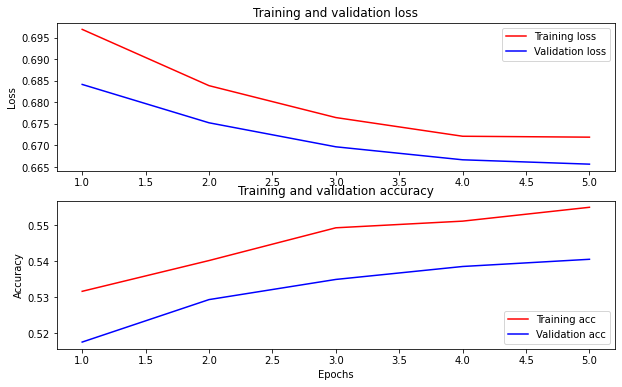

In [21]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [22]:
dataset_name = 'imdb'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

classifier_model.save(saved_model_path, include_optimizer=False)

In [23]:
reloaded_model = tf.saved_model.load(saved_model_path)

In [24]:
def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()


examples = [
    'this is such an amazing movie!',  # this is the same sentence tried earlier
    'The movie was great!',
    'The movie was meh.',
    'The movie was okish.',
    'The movie was terrible...'
]

reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))
original_results = tf.sigmoid(classifier_model(tf.constant(examples)))

print('Results from the saved model:')
print_my_examples(examples, reloaded_results)
print('Results from the model in memory:')
print_my_examples(examples, original_results)

Results from the saved model:
input: this is such an amazing movie! : score: 0.628785
input: The movie was great!           : score: 0.508253
input: The movie was meh.             : score: 0.299553
input: The movie was okish.           : score: 0.400397
input: The movie was terrible...      : score: 0.333527

Results from the model in memory:
input: this is such an amazing movie! : score: 0.628785
input: The movie was great!           : score: 0.508253
input: The movie was meh.             : score: 0.299553
input: The movie was okish.           : score: 0.400397
input: The movie was terrible...      : score: 0.333527



In [25]:
serving_results = reloaded_model \
            .signatures['serving_default'](tf.constant(examples))

serving_results = tf.sigmoid(serving_results['classifier'])

print_my_examples(examples, serving_results)

input: this is such an amazing movie! : score: 0.628785
input: The movie was great!           : score: 0.508253
input: The movie was meh.             : score: 0.299553
input: The movie was okish.           : score: 0.400397
input: The movie was terrible...      : score: 0.333527

